# Human Action Recognition with OpenVINO™

This notebook demonstrates live human action recognition with OpenVINO, using the [Action Recognition Models](https://docs.openvino.ai/2020.2/usergroup13.html) from [Open Model Zoo](https://github.com/openvinotoolkit/open_model_zoo), specifically an [Encoder](https://docs.openvino.ai/2020.2/_models_intel_action_recognition_0001_encoder_description_action_recognition_0001_encoder.html) and a [Decoder](https://docs.openvino.ai/2020.2/_models_intel_action_recognition_0001_decoder_description_action_recognition_0001_decoder.html). Both models create a sequence to sequence (`"seq2seq"`) \[1\] system to identify the human activities for [Kinetics-400 dataset](https://deepmind.com/research/open-source/kinetics). The models use the Video Transformer approach with ResNet34 encoder \[2\]. The notebook shows how to create the following pipeline:

<img align='center' src="https://user-images.githubusercontent.com/10940214/148401661-477aebcd-f2d0-4771-b107-4b37f94d0b1e.jpeg" alt="drawing" width="1000"/>

Final part of this notebook shows live inference results from a webcam. Additionally, you can also upload a video file.

**NOTE**: To use a webcam, you must run this Jupyter notebook on a computer with a webcam. If you run on a server, the webcam will not work. However, you can still do inference on a video in the final step.

---

\[1\] seq2seq: Deep learning models that take a sequence of items to the input and output. In this case, input: video frames, output: actions sequence. This `"seq2seq"` is composed of an encoder and a decoder. The encoder captures `"context"` of the inputs to be analyzed by the decoder, and finally gets the human action and confidence.

\[2\] [Video Transformer](https://en.wikipedia.org/wiki/Transformer_(machine_learning_model)) and [ResNet34](https://pytorch.org/vision/main/models/generated/torchvision.models.resnet34.html).



#### Table of contents:

- [Imports](#Imports)
- [The models](#The-models)
    - [Download the models](#Download-the-models)
    - [Load your labels](#Load-your-labels)
    - [Load the models](#Load-the-models)
        - [Model Initialization function](#Model-Initialization-function)
        - [Initialization for Encoder and Decoder](#Initialization-for-Encoder-and-Decoder)
    - [Helper functions](#Helper-functions)
    - [AI Functions](#AI-Functions)
    - [Main Processing Function](#Main-Processing-Function)
    - [Run Action Recognition](#Run-Action-Recognition)



In [1]:
%pip install -q "openvino>=2024.0.0" "opencv-python" "tqdm" "python-dotenv" "spacy" "nltk"

Note: you may need to restart the kernel to use updated packages.


In [2]:
import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet
wordnet.synsets('stare')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\shafa\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


[Synset('stare.n.01'), Synset('gaze.v.01'), Synset('stare.v.02')]

In [3]:
wordnet.synset('stare.v.02').hypernyms() 

[Synset('look.v.01')]

In [4]:
wordnet.synset('think.v.01').definition()

'judge or regard; look upon; judge'

In [5]:
wordnet.synset('evaluate.v.02').definition()

'form a critical opinion of'

In [6]:
wordnet.synset('think.v.03').definition()

"use or exercise the mind or one's power of reason in order to make inferences, decisions, or arrive at a solution or judgments"

In [7]:
wordnet.synset('evaluate.v.02').hypernyms() 

[Synset('think.v.03')]

In [8]:
wordnet.synset('think.v.03').hypernyms() 

[]

In [9]:
from nltk.wsd import lesk 
caption = ['catching', 'or', 'throwing', 'frisbee'] 
print(lesk(caption, 'catching')) 


Synset('get.v.11')


In [10]:
wordnet.synset('get.v.11').definition()

'succeed in catching or seizing, especially after a chase'

In [11]:
wordnet.synset('get.v.11').hypernyms() 

[Synset('seize.v.01')]

In [12]:
wordnet.synset('seize.v.01').definition()

'take hold of; grab'

In [13]:
wordnet.synset('exercise.v.03').hypernyms() 

[Synset('work.v.12')]

In [14]:
wordnet.synset('rise.v.04').definition()

'rise up'

In [15]:
wordnet.synset('rise.v.04').hypernyms() 

[Synset('look.v.02')]

In [16]:
wordnet.synsets('rise', pos=wordnet.VERB) 


[Synset('rise.v.01'),
 Synset('rise.v.02'),
 Synset('arise.v.03'),
 Synset('rise.v.04'),
 Synset('surface.v.01'),
 Synset('originate.v.01'),
 Synset('ascend.v.08'),
 Synset('wax.v.02'),
 Synset('heighten.v.01'),
 Synset('get_up.v.02'),
 Synset('rise.v.11'),
 Synset('rise.v.12'),
 Synset('rise.v.13'),
 Synset('rebel.v.01'),
 Synset('rise.v.15'),
 Synset('rise.v.16'),
 Synset('resurrect.v.03')]

In [17]:
import spacy
nlp = spacy.load("en_core_web_lg")
doc = nlp("Natural language processing, or NLP, combines computational linguistics—rule-based modeling of human language—with statistical and machine learning models to enable computers and digital devices to recognize, understand and generate text and speech.")

for token in doc:
    print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_,
            token.shape_, token.is_alpha, token.is_stop)

Natural natural ADJ JJ amod Xxxxx True False
language language NOUN NN compound xxxx True False
processing processing NOUN NN nsubj xxxx True False
, , PUNCT , punct , False False
or or CCONJ CC cc xx True True
NLP NLP PROPN NNP conj XXX True False
, , PUNCT , punct , False False
combines combine VERB VBZ ROOT xxxx True False
computational computational ADJ JJ amod xxxx True False
linguistics linguistic NOUN NNS dobj xxxx True False
— — PUNCT : punct — False False
rule rule NOUN NN npadvmod xxxx True False
- - PUNCT HYPH punct - False False
based base VERB VBN amod xxxx True False
modeling modeling NOUN NN appos xxxx True False
of of ADP IN prep xx True True
human human ADJ JJ amod xxxx True False
language language NOUN NN pobj xxxx True False
— — PUNCT : punct — False False
with with ADP IN prep xxxx True True
statistical statistical ADJ JJ amod xxxx True False
and and CCONJ CC cc xxx True True
machine machine NOUN NN conj xxxx True False
learning learning NOUN NN conj xxxx True False

## Imports
[back to top ⬆️](#Table-of-contents:)


In [18]:
import collections
import os
import time
import json
from typing import Tuple, List

from pathlib import Path
from dotenv import load_dotenv

import cv2
import numpy as np
from IPython import display
import openvino as ov

from openvino.runtime.ie_api import CompiledModel

# Fetch `notebook_utils` module
import requests

r = requests.get(
    url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/notebook_utils.py",
)
open("notebook_utils.py", "w").write(r.text)
import notebook_utils as utils

In [19]:
load_dotenv()
VIDEOS_PATH = os.environ['VIDEOS_PATH']
VIDEOS = os.listdir(VIDEOS_PATH)
VIDEO_CAPTION = os.environ['CAPTIONS']
print(VIDEOS)

['-5wLopwbGX0.mp4', '03dk7mneDU0.mp4', '1Hi5GMotrjs.mp4', '5l1ajLjqaPo.mp4', '8UxlDNur-Z0.mp4', '9GFfKVeoGm0.mp4', 'a58tBGuDIg0.mp4', 'A8TIWMvJVDU.mp4', 'AuqIu3x_lhY.mp4', 'c8ln_nWYMyM.mp4', 'czhL0iDbNT8.mp4', 'DYpTE_n-Wvk.mp4', 'F5Y_gGsg4x8.mp4', 'GI7nIyMEQi4.mp4', 'jf7RDuUTrsQ.mp4', 'jqkyelS4GJk.mp4', 'JTlatknwOrY.mp4', 'KPP2qRzMdos.mp4', 'NUG7kwJ-614.mp4', 'PmgfU9ocx5A.mp4', 'R-xmgefs-M4.mp4', 'ustVqWMM56c.mp4', 'wHUvw_R2iv8.mp4', 'y9r115bgfNk.mp4', 'ZnIDviwA8CE.mp4']


## The models
[back to top ⬆️](#Table-of-contents:)

### Download the models
[back to top ⬆️](#Table-of-contents:)

Use the `download_ir_model`, a function from the `notebook_utils` file. It automatically creates a directory structure and downloads the selected model.

In this case you can use `"action-recognition-0001"` as a model name, and the system automatically downloads the two models `"action-recognition-0001-encoder"` and `"action-recognition-0001-decoder"`

> **NOTE**: If you want to download another model, such as `"driver-action-recognition-adas-0002"` (`"driver-action-recognition-adas-0002-encoder"` + `"driver-action-recognition-adas-0002-decoder"`), replace the name of the model in the code below. Using a model outside the list can require different pre- and post-processing. 

In [20]:
#to store predictions of each frame
predictions_arr=[]
logs_file_path=os.getcwd() + "\\logs.txt"
open(logs_file_path, 'w').close()
# A directory where the model will be downloaded.
base_model_dir = "model"
# The name of the model from Open Model Zoo.
model_name = "action-recognition-0001"
# Selected precision (FP32, FP16, FP16-INT8).
precision = "FP16"
model_path_decoder = f"model/intel/{model_name}/{model_name}-decoder/{precision}/{model_name}-decoder.xml"
model_path_encoder = f"model/intel/{model_name}/{model_name}-encoder/{precision}/{model_name}-encoder.xml"
encoder_url = f"https://storage.openvinotoolkit.org/repositories/open_model_zoo/temp/{model_name}/{model_name}-encoder/{precision}/{model_name}-encoder.xml"
decoder_url = f"https://storage.openvinotoolkit.org/repositories/open_model_zoo/temp/{model_name}/{model_name}-decoder/{precision}/{model_name}-decoder.xml"

if not os.path.exists(model_path_decoder):
    utils.download_ir_model(decoder_url, Path(model_path_decoder).parent)
if not os.path.exists(model_path_encoder):
    utils.download_ir_model(encoder_url, Path(model_path_encoder).parent)

### Load your labels
[back to top ⬆️](#Table-of-contents:)

This tutorial uses [Kinetics-400 dataset](https://deepmind.com/research/open-source/kinetics), and also provides the text file embedded into this notebook. 

> **NOTE**: If you want to run `"driver-action-recognition-adas-0002"` model, replace the `kinetics.txt` file to `driver_actions.txt`.

In [21]:
# Download the text from the openvino_notebooks storage
vocab_file_path = utils.download_file(
    "https://storage.openvinotoolkit.org/repositories/openvino_notebooks/data/data/text/kinetics.txt",
    directory="data",
)

with vocab_file_path.open(mode="r") as f:
    labels = [line.strip() for line in f]

print(labels[0:9], np.shape(labels))


'data\kinetics.txt' already exists.
['abseiling', 'air drumming', 'answering questions', 'applauding', 'applying cream', 'archery', 'arm wrestling', 'arranging flowers', 'assembling computer'] (400,)


### Load the models
[back to top ⬆️](#Table-of-contents:)

Load the two models for this particular architecture, Encoder and Decoder. Downloaded models are located in a fixed structure, indicating a vendor, the name of the model, and a precision.

 1. Initialize OpenVINO Runtime.
 2. Read the network from `*.bin` and `*.xml` files (weights and architecture).
 3. Compile the model for specified device.
 4. Get input and output names of nodes.

Only a few lines of code are required to run the model.

Select device from dropdown list for running inference using OpenVINO

In [22]:
import ipywidgets as widgets

core = ov.Core()
device = widgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value="AUTO",
    description="Device:",
    disabled=False,
)

device

Dropdown(description='Device:', index=2, options=('CPU', 'GPU', 'AUTO'), value='AUTO')

#### Model Initialization function
[back to top ⬆️](#Table-of-contents:)


In [23]:
# Initialize OpenVINO Runtime.
core = ov.Core()


def model_init(model_path: str, device: str) -> Tuple:
    """
    Read the network and weights from a file, load the
    model on CPU and get input and output names of nodes

    :param:
            model: model architecture path *.xml
            device: inference device
    :retuns:
            compiled_model: Compiled model
            input_key: Input node for model
            output_key: Output node for model
    """

    # Read the network and corresponding weights from a file.
    model = core.read_model(model=model_path)
    l_file = open(logs_file_path, "a")  # append mode
    l_file.write("\nmodel:\n" )
    l_file.write(str(model ))
    l_file.close()
    # Compile the model for specified device.
    compiled_model = core.compile_model(model=model, device_name=device)
    # Get input and output names of nodes.
    input_keys = compiled_model.input(0)
    l_file = open(logs_file_path, "a")  # append mode
    l_file.write("\ninput keys:\n" )
    l_file.write(str(input_keys ))
    l_file.close()
    output_keys = compiled_model.output(0)
    return input_keys, output_keys, compiled_model

#### Initialization for Encoder and Decoder
[back to top ⬆️](#Table-of-contents:)


In [24]:
l_file = open(logs_file_path, "a")  # append mode
l_file.write("\nmodel peth encoder:\n" )
l_file.write(str(model_path_encoder ))
l_file.write("\nmodel peth decoder:\n" )
l_file.write(str(model_path_decoder ))
l_file.close()
# Encoder initialization
input_key_en, output_keys_en, compiled_model_en = model_init(model_path_encoder, device.value)
# Decoder initialization
input_key_de, output_keys_de, compiled_model_de = model_init(model_path_decoder, device.value)

# Get input size - Encoder.
height_en, width_en = list(input_key_en.shape)[2:]
# Get input size - Decoder.
frames2decode = list(input_key_de.shape)[0:][1]
print(frames2decode)

16


### Helper functions
[back to top ⬆️](#Table-of-contents:)

Use the following helper functions for preprocessing and postprocessing frames:

1. Preprocess the input image before running the Encoder model. (`center_crop` and `adaptative_resize`)
2. Decode top-3 probabilities into label names. (`decode_output`)
3. Draw the Region of Interest (ROI) over the video. (`rec_frame_display`)
4. Prepare the frame for displaying label names over the video. (`display_text_fnc`)

In [25]:
def center_crop(frame: np.ndarray) -> np.ndarray:
    """
    Center crop squared the original frame to standardize the input image to the encoder model

    :param frame: input frame
    :returns: center-crop-squared frame
    """
    img_h, img_w, _ = frame.shape
    min_dim = min(img_h, img_w)
    start_x = int((img_w - min_dim) / 2.0)
    start_y = int((img_h - min_dim) / 2.0)
    roi = [start_y, (start_y + min_dim), start_x, (start_x + min_dim)]
    return frame[start_y : (start_y + min_dim), start_x : (start_x + min_dim), ...], roi


def adaptive_resize(frame: np.ndarray, size: int) -> np.ndarray:
    """
     The frame going to be resized to have a height of size or a width of size

    :param frame: input frame
    :param size: input size to encoder model
    :returns: resized frame, np.array type
    """
    h, w, _ = frame.shape
    scale = size / min(h, w)
    w_scaled, h_scaled = int(w * scale), int(h * scale)
    if w_scaled == w and h_scaled == h:
        return frame
    return cv2.resize(frame, (w_scaled, h_scaled))


def decode_output(probs: np.ndarray, labels: np.ndarray, top_k: int = 3) -> np.ndarray:
    """
    Decodes top probabilities into corresponding label names

    :param probs: confidence vector for 400 actions
    :param labels: list of actions
    :param top_k: The k most probable positions in the list of labels
    :returns: decoded_labels: The k most probable actions from the labels list
              decoded_top_probs: confidence for the k most probable actions
    """
    top_ind = np.argsort(-1 * probs)[:top_k]
    out_label = np.array(labels)[top_ind.astype(int)]
    decoded_labels = [out_label[0][0], out_label[0][1], out_label[0][2]]
    top_probs = np.array(probs)[0][top_ind.astype(int)]
    decoded_top_probs = [top_probs[0][0], top_probs[0][1], top_probs[0][2]]
    return decoded_labels, decoded_top_probs


def rec_frame_display(frame: np.ndarray, roi) -> np.ndarray:
    """
    Draw a rec frame over actual frame

    :param frame: input frame
    :param roi: Region of interest, image section processed by the Encoder
    :returns: frame with drawed shape

    """

    cv2.line(frame, (roi[2] + 3, roi[0] + 3), (roi[2] + 3, roi[0] + 100), (0, 200, 0), 2)
    cv2.line(frame, (roi[2] + 3, roi[0] + 3), (roi[2] + 100, roi[0] + 3), (0, 200, 0), 2)
    cv2.line(frame, (roi[3] - 3, roi[1] - 3), (roi[3] - 3, roi[1] - 100), (0, 200, 0), 2)
    cv2.line(frame, (roi[3] - 3, roi[1] - 3), (roi[3] - 100, roi[1] - 3), (0, 200, 0), 2)
    cv2.line(frame, (roi[3] - 3, roi[0] + 3), (roi[3] - 3, roi[0] + 100), (0, 200, 0), 2)
    cv2.line(frame, (roi[3] - 3, roi[0] + 3), (roi[3] - 100, roi[0] + 3), (0, 200, 0), 2)
    cv2.line(frame, (roi[2] + 3, roi[1] - 3), (roi[2] + 3, roi[1] - 100), (0, 200, 0), 2)
    cv2.line(frame, (roi[2] + 3, roi[1] - 3), (roi[2] + 100, roi[1] - 3), (0, 200, 0), 2)
    # Write ROI over actual frame
    FONT_STYLE = cv2.FONT_HERSHEY_SIMPLEX
    org = (roi[2] + 3, roi[1] - 3)
    org2 = (roi[2] + 2, roi[1] - 2)
    FONT_SIZE = 0.5
    FONT_COLOR = (0, 200, 0)
    FONT_COLOR2 = (0, 0, 0)
    cv2.putText(frame, "ROI", org2, FONT_STYLE, FONT_SIZE, FONT_COLOR2)
    cv2.putText(frame, "ROI", org, FONT_STYLE, FONT_SIZE, FONT_COLOR)
    return frame


def display_text_fnc(frame: np.ndarray, display_text: str, index: int):
    """
    Include a text on the analyzed frame

    :param frame: input frame
    :param display_text: text to add on the frame
    :param index: index line dor adding text

    """
    # Configuration for displaying images with text.
    FONT_COLOR = (255, 255, 255)
    FONT_COLOR2 = (0, 0, 0)
    FONT_STYLE = cv2.FONT_HERSHEY_DUPLEX
    FONT_SIZE = 0.7
    TEXT_VERTICAL_INTERVAL = 25
    TEXT_LEFT_MARGIN = 15
    # ROI over actual frame
    (processed, roi) = center_crop(frame)
    # Draw a ROI over actual frame.
    frame = rec_frame_display(frame, roi)
    # Put a text over actual frame.
    text_loc = (TEXT_LEFT_MARGIN, TEXT_VERTICAL_INTERVAL * (index + 1))
    text_loc2 = (TEXT_LEFT_MARGIN + 1, TEXT_VERTICAL_INTERVAL * (index + 1) + 1)
    cv2.putText(frame, display_text, text_loc2, FONT_STYLE, FONT_SIZE, FONT_COLOR2)
    cv2.putText(frame, display_text, text_loc, FONT_STYLE, FONT_SIZE, FONT_COLOR)

### AI Functions
[back to top ⬆️](#Table-of-contents:)

<img align='center' src="https://user-images.githubusercontent.com/10940214/148401661-477aebcd-f2d0-4771-b107-4b37f94d0b1e.jpeg" alt="drawing" width="1000"/>

Following the pipeline above, you will use the next functions to:

1. Preprocess a frame before running the Encoder. (`preprocessing`)
2. Encoder Inference per frame. (`encoder`)
3. Decoder inference per set of frames. (`decoder`)
4. Normalize the Decoder output to get confidence values per action recognition label. (`softmax`)

In [26]:
def preprocessing(frame: np.ndarray, size: int) -> np.ndarray:
    """
    Preparing frame before Encoder.
    The image should be scaled to its shortest dimension at "size"
    and cropped, centered, and squared so that both width and
    height have lengths "size". The frame must be transposed from
    Height-Width-Channels (HWC) to Channels-Height-Width (CHW).

    :param frame: input frame
    :param size: input size to encoder model
    :returns: resized and cropped frame
    """
    # Adaptative resize
    preprocessed = adaptive_resize(frame, size)
    # Center_crop
    (preprocessed, roi) = center_crop(preprocessed)
    # Transpose frame HWC -> CHW
    preprocessed = preprocessed.transpose((2, 0, 1))[None,]  # HWC -> CHW
    return preprocessed, roi


def encoder(preprocessed: np.ndarray, compiled_model: CompiledModel) -> List:
    """
    Encoder Inference per frame. This function calls the network previously
    configured for the encoder model (compiled_model), extracts the data
    from the output node, and appends it in an array to be used by the decoder.

    :param: preprocessed: preprocessing frame
    :param: compiled_model: Encoder model network
    :returns: encoder_output: embedding layer that is appended with each arriving frame
    """
    output_key_en = compiled_model.output(0)

    # Get results on action-recognition-0001-encoder model
    infer_result_encoder = compiled_model([preprocessed])[output_key_en]
    return infer_result_encoder


def decoder(encoder_output: List, compiled_model_de: CompiledModel) -> List:
    """
    Decoder inference per set of frames. This function concatenates the embedding layer
    froms the encoder output, transpose the array to match with the decoder input size.
    Calls the network previously configured for the decoder model (compiled_model_de), extracts
    the logits and normalize those to get confidence values along specified axis.
    Decodes top probabilities into corresponding label names

    :param: encoder_output: embedding layer for 16 frames
    :param: compiled_model_de: Decoder model network
    :returns: decoded_labels: The k most probable actions from the labels list
              decoded_top_probs: confidence for the k most probable actions
    """
    # Concatenate sample_duration frames in just one array
    decoder_input = np.concatenate(encoder_output, axis=0)
    # Organize input shape vector to the Decoder (shape: [1x16x512]]
    decoder_input = decoder_input.transpose((2, 0, 1, 3))
    decoder_input = np.squeeze(decoder_input, axis=3)
    output_key_de = compiled_model_de.output(0)
    # Get results on action-recognition-0001-decoder model
    result_de = compiled_model_de([decoder_input])[output_key_de]
    # Normalize logits to get confidence values along specified axis
    probs = softmax(result_de - np.max(result_de))
    # Decodes top probabilities into corresponding label names
    decoded_labels, decoded_top_probs = decode_output(probs, labels, top_k=3)
    return decoded_labels, decoded_top_probs


def softmax(x: np.ndarray) -> np.ndarray:
    """
    Normalizes logits to get confidence values along specified axis
    x: np.array, axis=None
    """
    exp = np.exp(x)
    return exp / np.sum(exp, axis=None)

### Main Processing Function
[back to top ⬆️](#Table-of-contents:)

Running action recognition function will run in different operations, either a webcam or a video file. See the list of procedures below:

1. Create a video player to play with target fps (`utils.VideoPlayer`).
2. Prepare a set of frames to be encoded-decoded.
3. Run AI functions
4. Visualize the results.

In [27]:
def run_action_recognition(
    source: str = "0",
    flip: bool = True,
    use_popup: bool = False,
    compiled_model_en: CompiledModel = compiled_model_en,
    compiled_model_de: CompiledModel = compiled_model_de,
    skip_first_frames: int = 0,
    predictions_arr: list = []
):
    """
    Use the "source" webcam or video file to run the complete pipeline for action-recognition problem
    1. Create a video player to play with target fps
    2. Prepare a set of frames to be encoded-decoded
    3. Preprocess frame before Encoder
    4. Encoder Inference per frame
    5. Decoder inference per set of frames
    6. Visualize the results

    :param: source: webcam "0" or video path
    :param: flip: to be used by VideoPlayer function for flipping capture image
    :param: use_popup: False for showing encoded frames over this notebook, True for creating a popup window.
    :param: skip_first_frames: Number of frames to skip at the beginning of the video.
    :returns: display video over the notebook or in a popup window

    """
    size = height_en  # Endoder input size - From Cell 5_9
    sample_duration = frames2decode  # Decoder input size - From Cell 5_7
    # Select frames per second of your source.
    fps = 30
    player = None
    try:
        # Create a video player.
        player = utils.VideoPlayer(source, flip=flip, fps=fps, skip_first_frames=skip_first_frames)
        # Start capturing.
        player.start()
        if use_popup:
            title = "Press ESC to Exit"
            cv2.namedWindow(title, cv2.WINDOW_GUI_NORMAL | cv2.WINDOW_AUTOSIZE)

        processing_times = collections.deque()
        processing_time = 0
        encoder_output = []
        decoded_labels = [0, 0, 0]
        decoded_top_probs = [0, 0, 0]
        counter = 0
        # Create a text template to show inference results over video.
        text_inference_template = "Infer Time:{Time:.1f}ms,{fps:.1f}FPS"
        text_template = "{label},{conf:.2f}%"

        while True:
            counter = counter + 1

            # Read a frame from the video stream.
            frame = player.next()
            if frame is None:
                print("Source ended")
                break

            scale = 1280 / max(frame.shape)

            # Adaptative resize for visualization.
            if scale < 1:
                frame = cv2.resize(frame, None, fx=scale, fy=scale, interpolation=cv2.INTER_AREA)

            # Select one frame every two for processing through the encoder.
            # After 16 frames are processed, the decoder will find the action,
            # and the label will be printed over the frames.

            if counter % 2 == 0:
                # Preprocess frame before Encoder.
                (preprocessed, _) = preprocessing(frame, size)

                # Measure processing time.
                start_time = time.time()

                # Encoder Inference per frame
                encoder_output.append(encoder(preprocessed, compiled_model_en))
                l_file = open(logs_file_path, "a")  # append mode
                l_file.write("\nbefore decoder\n" )
                l_file.close()
                # Decoder inference per set of frames
                # Wait for sample duration to work with decoder model.
                if len(encoder_output) == sample_duration:
                    decoded_labels, decoded_top_probs = decoder(encoder_output, compiled_model_de)
                    for i in range(0, 3):
                        if i == 0:
                            predictions_arr.append([])
                        predictions_arr[-1].append({'label': str(decoded_labels[i]), 'confidence': str(decoded_top_probs[i] * 100)})
                    encoder_output = []

                # Inference has finished. Display the results.
                stop_time = time.time()

                # Calculate processing time.
                processing_times.append(stop_time - start_time)

                # Use processing times from last 200 frames.
                if len(processing_times) > 200:
                    processing_times.popleft()

                # Mean processing time [ms]
                processing_time = np.mean(processing_times) * 1000
                fps = 1000 / processing_time
            # Visualize the results.
            for i in range(0, 3):
                display_text = text_template.format(
                    label=decoded_labels[i],
                    conf=decoded_top_probs[i] * 100,
                )
                display_text_fnc(frame, display_text, i)
            display_text = text_inference_template.format(Time=processing_time, fps=fps)
            display_text_fnc(frame, display_text, 3)

            # Use this workaround if you experience flickering.
            if use_popup:
                cv2.imshow(title, frame)
                key = cv2.waitKey(1)
                # escape = 27
                if key == 27:
                    break
            else:
                # Encode numpy array to jpg.
                _, encoded_img = cv2.imencode(".jpg", frame, params=[cv2.IMWRITE_JPEG_QUALITY, 90])
                # Create an IPython image.
                i = display.Image(data=encoded_img)
                # Display the image in this notebook.
                display.clear_output(wait=True)
                display.display(i)
    # ctrl-c
    except KeyboardInterrupt:
        print("Interrupted")
    # Any different error
    except RuntimeError as e:
        print(e)
    finally:
        if player is not None:
            # Stop capturing.
            player.stop()
        if use_popup:
            cv2.destroyAllWindows()

### Run Action Recognition
[back to top ⬆️](#Table-of-contents:)

Find out how the model works in a video file. [Any format supported](https://docs.opencv.org/4.5.1/dd/d43/tutorial_py_video_display.html) by OpenCV will work. You can press the stop button anytime while the video file is running, and it will activate the webcam for the next step.

> **NOTE**: Sometimes, the video can be cut off if there are corrupted frames. In that case, you can convert it. If you experience any problems with your video, use the [HandBrake](https://handbrake.fr/) and select the MPEG format.

if you want to use a web camera as an input source for the demo, please change the value of `USE_WEBCAM` variable to True and specify `cam_id` (the default value is 0, which can be different in multi-camera systems).

In [28]:
# %pip install pafy

In [29]:
# %pip install --upgrade youtube-dl

In [30]:
l_file = open(logs_file_path, "a")  # append mode
l_file.write("\ntest var: \n" + json.dumps(predictions_arr, indent = 4) + "\n" )
l_file.close()


In [31]:
print(os.environ.get('VIDEOS_PATH'))#os.environ['VIDEO_PATH']

D:\Downloads\test_conf_metrix\videos


In [32]:
print(type(VIDEOS))

<class 'list'>


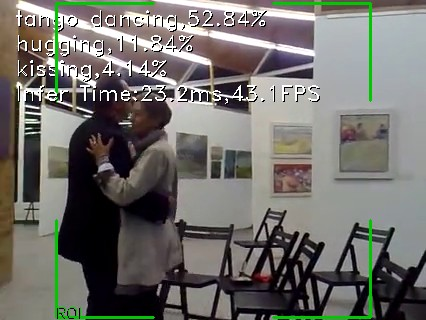

Source ended
<class 'str'>


In [33]:

# import pafy

USE_WEBCAM = False

cam_id = 0
#video_file = "https://www.youtube.com/embed/0347ZoDXyP0?start=95&end=105&ref=autodidacts.io" #not working
#video_file = "https://www.youtube.com/watch?v=0347ZoDXyP0"  #not working
#video = pafy.new("https://www.youtube.com/watch?v=0347ZoDXyP0") #not working
#video_file = video.getbest(preftype="mp4") #not working
# got VIDEO_PATH through environment variable
for video in VIDEOS:
    video_file = VIDEOS_PATH + "\\" + video
    source = cam_id if USE_WEBCAM else video_file
    additional_options = {"skip_first_frames": 0, "flip": False} if not USE_WEBCAM else {"flip": True}
    run_action_recognition(source=source, use_popup=False, predictions_arr=predictions_arr, **additional_options)
    with open(os.getcwd() + "\\logs.json", "w") as outfile:
        outfile.write(json.dumps(predictions_arr,  indent=4))
    l_file = open(logs_file_path, "a")  # append mode
    l_file.write("output of predictions written into " + os.getcwd() + "\\logs.json" )
    l_file.close()
    sorted_predictions = []
    tmp_s_p = {}
    no_of_frames = 0
    for frame in predictions_arr:
        no_of_frames = no_of_frames + 1
        for prediction in frame:
            if prediction['label'] in tmp_s_p.keys():
                tmp_s_p[prediction['label']] = float(tmp_s_p[prediction['label']]) + float(prediction['confidence'])
            else:
                tmp_s_p[prediction['label']] = float(prediction['confidence'])
    for pred in tmp_s_p:
        tmp_s_p[pred] = tmp_s_p[pred]/no_of_frames
    print(type(predictions_arr[0][0]['confidence']))
    while tmp_s_p:
        key = max(zip(tmp_s_p.values(), tmp_s_p.keys()))[1]
        value = max(zip(tmp_s_p.values(), tmp_s_p.keys()))[0]
        sorted_predictions.append({'name': key, 'value': value})
        tmp_s_p.pop(key)

In [34]:
sorted_predictions

[{'name': 'massaging back', 'value': 4.716207990140626},
 {'name': 'presenting weather forecast', 'value': 4.114251167743237},
 {'name': 'carving pumpkin', 'value': 3.7132053406207595},
 {'name': 'drawing', 'value': 3.5734794356606225},
 {'name': 'doing nails', 'value': 3.281898544980334},
 {'name': 'stretching arm', 'value': 3.1000258844523203},
 {'name': 'playing controller', 'value': 2.1152291850094156},
 {'name': 'passing American football (in game)', 'value': 2.1024550710405623},
 {'name': 'cooking on campfire', 'value': 2.062043560531748},
 {'name': 'pushing cart', 'value': 1.83011455969377},
 {'name': 'massaging legs', 'value': 1.6073823321884844},
 {'name': 'tap dancing', 'value': 1.3389492415504538},
 {'name': 'opening present', 'value': 1.1994592200367997},
 {'name': 'playing saxophone', 'value': 1.0867711962946565},
 {'name': 'motorcycling', 'value': 1.0509236485927136},
 {'name': 'exercising arm', 'value': 1.049724750188522},
 {'name': 'jumpstyle dancing', 'value': 0.956953